## Loading Drive State and Importing Functions 
Load in the proper google drive state and functions needed to perform the face identity recognition task. In order for this to properly work, the celeb_a_train, celeb_a_test, and the id text file must all be present in a celeb_data folder prior to running!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import zipfile
import time
import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models
import matplotlib
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm


## Fetching Corresponding Zipfiles and Txtfiles located in celeb_data drive folder 

Make sure the naming conventions are followed as shown below in your celeb_data folder. Otherwise, this section will NOT work! 
$$\\ $$ 


In [ ]:
with zipfile.ZipFile("./drive/MyDrive/celeb_data/Copy of celeba_train_for_RA.zip", 'r') as zip:
  zip.extractall(path='./data/train')

In [ ]:
with zipfile.ZipFile("./drive/MyDrive/celeb_data/Copy of celeba_test_for_RA.zip", 'r') as zip:
  zip.extractall(path='./data/test')

In [ ]:
df = pd.read_fwf('./drive/MyDrive/celeb_data/identity_CelebA.txt')
df.rename(columns = {'img label' : 'img', 'Unnamed: 1': 'label'},inplace = True)
df = df.reset_index(drop = True)

## Carrying out Deletion of all Images that are not Present in Subset 

In order to avoid errors in the DataLoader further down the line, all ids that do not occur in the small subset of images must be deleted before creating the folders necessary for the task.
$$\\ $$ 


In [ ]:
array = df.to_numpy().tolist()
for values in range(len(array)):
  temp = str(array[values][0]) + ' ' + str(array[values][1])
  array[values] = ''
  array[values] = temp
array = set(array)


In [ ]:
img_list1 =set(os.listdir('./data/train/celeba_train_for_rosie'))
img_list2 = set(os.listdir('./data/test/celeba_test_for_rosie'))
print(len(img_list1) + len(img_list2))
print(len(array))
for values in array.copy():
  if values.split(' ')[0] in img_list1 or values.split(' ')[0] in img_list2:
      continue
  array.remove(values)
print(len(array))


30212
202599
30211


## Making Folders for ids that correlate to the right images

Create directories and subsequently populate directories with the corresponding images in order to properly use ImageFolder class.
$$\\ $$ 


In [ ]:
array = [values.split(' ') for values in array]
array 

[['174158.jpg', '1882'],
 ['042580.jpg', '999'],
 ['019410.jpg', '247'],
 ['124562.jpg', '1527'],
 ['168388.jpg', '2152'],
 ['046563.jpg', '449'],
 ['077437.jpg', '1005'],
 ['020043.jpg', '647'],
 ['050422.jpg', '1035'],
 ['105563.jpg', '1040'],
 ['162808.jpg', '1455'],
 ['042926.jpg', '1939'],
 ['011231.jpg', '2010'],
 ['110117.jpg', '418'],
 ['116470.jpg', '344'],
 ['091052.jpg', '1028'],
 ['178204.jpg', '796'],
 ['025679.jpg', '357'],
 ['171213.jpg', '1415'],
 ['063872.jpg', '2117'],
 ['038785.jpg', '2013'],
 ['137327.jpg', '166'],
 ['002722.jpg', '863'],
 ['082553.jpg', '1968'],
 ['170950.jpg', '1004'],
 ['094232.jpg', '1797'],
 ['165202.jpg', '875'],
 ['174352.jpg', '261'],
 ['053333.jpg', '215'],
 ['173626.jpg', '228'],
 ['106353.jpg', '1148'],
 ['111756.jpg', '206'],
 ['134030.jpg', '750'],
 ['020903.jpg', '187'],
 ['123499.jpg', '362'],
 ['034539.jpg', '1617'],
 ['071223.jpg', '1744'],
 ['057449.jpg', '578'],
 ['015109.jpg', '992'],
 ['117762.jpg', '1554'],
 ['170872.jpg', '573

In [ ]:
df = pd.DataFrame(array, columns = {'img','label'})
df= df.sort_values(by = ['img']).reset_index(drop = True)
df

,label,img
0,056279.jpg,1
1,015216.jpg,1
2,027827.jpg,1
3,111433.jpg,1
4,006439.jpg,1
...,...,...
30206,005913.jpg,999
30207,048936.jpg,999
30208,089153.jpg,999
30209,000122.jpg,999


In [ ]:
img_list1 = list(img_list1)
print(len(set(df['label'])),len(set(df['img'])))

30211 1503


In [ ]:
s=  {}
for values in range(len(array)):
  if array[values][1] not in s:
    s[array[values][1]] = [array[values][0]]
  else:
    s[array[values][1]].append(array[values][0])
s['3']

['034630.jpg',
 '043469.jpg',
 '093256.jpg',
 '113790.jpg',
 '079834.jpg',
 '024085.jpg',
 '003029.jpg',
 '121749.jpg',
 '016811.jpg',
 '003206.jpg',
 '008838.jpg',
 '122082.jpg',
 '045833.jpg',
 '047989.jpg',
 '095762.jpg',
 '047009.jpg',
 '021233.jpg',
 '110393.jpg',
 '067332.jpg',
 '072785.jpg',
 '016933.jpg']

In [ ]:
img_list1 = set(img_list1)
img_list2 = set(img_list2) 

for values in s:
  for i in range(len(s[values])):
    if s[values][i] in img_list1:
      try:
        os.mkdir('./data/train/celeba_train_for_rosie/' + values)
        shutil.move('./data/train/celeba_train_for_rosie/' + s[values][i], './data/train/celeba_train_for_rosie/' + values + '/' + s[values][i])
      except:  
        shutil.move('./data/train/celeba_train_for_rosie/' + s[values][i], './data/train/celeba_train_for_rosie/' + values + '/' + s[values][i])
    else: 
      try:
        os.mkdir('./data/test/celeba_test_for_rosie/' + values) 
        shutil.move('./data/test/celeba_test_for_rosie/' + s[values][i], './data/test/celeba_test_for_rosie/' + values + '/' + s[values][i])
      except:
        shutil.move('./data/test/celeba_test_for_rosie/' + s[values][i], './data/test/celeba_test_for_rosie/' + values + '/' + s[values][i])

  
  


## Transforming and Loading in Image Data into Tensors

In order to achieve a sufficient accuracy, images are randomly flipped and resize cropped. Grayscaling was decided against because the model (ResNet18) supports a 3 channel convolutional input instead of the 1 channel provided by grayscaling
$$\\ $$ 


In [ ]:
train_tfms = tt.Compose([
    tt.Resize((224,224)),
                         tt.RandomResizedCrop(224), 
                         tt.RandomHorizontalFlip(),
                        #  tt.Grayscale(),
                         tt.ToTensor()])

valid_tfms = tt.Compose([
    tt.Resize((224,224)),
    tt.CenterCrop((224,224)),
    # tt.Grayscale(),
    tt.ToTensor()])
print(s.keys())

dict_keys(['1882', '999', '247', '1527', '2152', '449', '1005', '647', '1035', '1040', '1455', '1939', '2010', '418', '344', '1028', '796', '357', '1415', '2117', '2013', '166', '863', '1968', '1004', '1797', '875', '261', '215', '228', '1148', '206', '750', '187', '362', '1617', '1744', '578', '992', '1554', '573', '94', '2105', '654', '1843', '1710', '1938', '2181', '988', '18', '1146', '1950', '1214', '272', '172', '467', '1862', '555', '614', '1693', '1115', '92', '66', '1281', '2074', '1164', '953', '1916', '115', '46', '1448', '1426', '549', '623', '1366', '374', '797', '25', '870', '1296', '2092', '1538', '958', '702', '1631', '358', '1892', '718', '227', '2110', '1301', '485', '505', '2121', '892', '1915', '452', '2174', '1150', '1504', '1785', '631', '54', '1392', '1059', '271', '320', '1325', '155', '130', '164', '2015', '2182', '1690', '858', '1858', '547', '1317', '1022', '366', '409', '1038', '1073', '612', '265', '1574', '981', '798', '2129', '170', '1755', '262', '942', 

In [ ]:
train_ds = ImageFolder('./data/train/celeba_train_for_rosie',train_tfms)
valid_ds = ImageFolder('./data/test/celeba_test_for_rosie',valid_tfms)

len_train = len(train_ds)
len_valid = len(valid_ds)

In [ ]:
batch_size = 12

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 8)
valid_dl = DataLoader(valid_ds, batch_size, num_workers = 8)


## Plotting the images in batches 

Functions below plot images in order to make sure images are properly loaded
$$\\ $$ 

In [ ]:
def denormalize(images, means, stds):
    print(images.shape())
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    print(images.shape())
    return images * stds + means

def show_batch(dl,ds):
    for images,labels in ds:
      print(images[0].shape)
      break
    for images, labels in dl:
        print(images[0].shape)
        print(len(images),len(set(labels)))
        fig, ax = plt.subplots(figsize=(40, 40))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
show_batch(train_dl, valid_dl)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
20 20


## Initializing, Training and Fitting the Model 

Making sure the GPU device is possible to be utilized firstly. Then, utilizing a resnet18 architecture with a slihtly changed model.fc attribute which is curtailed to our number of classes used. For loss, cross entropy is used while for optimization Stochastic Gradient Descent is used. 

In addition, a 'one size fits all' train and fit function was created which can be used to fit to any other models. The function prints out the current epoch,
the total epoch loss, the epoch accuracy and how much time has passed since starting for both training and validation. Function also saves for whatever name selected

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
model = models.resnet18(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_ds.classes))
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
def train_and_fit(EPOCHS, model, train_dl, valid_dl, train_ds, valid_ds, loss_fn, optim, model_name = 'model'):
  st_time = time.time()

  for epoch in range(EPOCHS):
    model.train()
    curr_loss= 0.
    curr_correct = 0
    
    ## in sample metrics 

    for i, (images, labels) in enumerate(train_dl):
      images = images.to(device)
      labels = labels.to(device)
      optim.zero_grad()
      outputs = model(images)
      _, preds = torch.max(outputs , 1)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optim.step()
      curr_loss = loss.item() * images.size(0)
      curr_correct += torch.sum(preds == labels.data)
    
    e_loss = curr_loss / len(train_ds)
    e_acc = curr_correct / len(train_ds) * 100
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'
    .format(epoch + 1, e_loss, e_acc, time.time() -st_time))

    model.eval()

    ## out of sample metrics 

    with torch.no_grad():
      curr_loss = 0.
      curr_correct = 0

      for images, labels in valid_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        curr_loss += loss.item() * images.size(0)
        curr_correct += torch.sum(preds == labels.data)
      
      
      e_loss = curr_loss / len(valid_ds)
      e_acc = curr_correct / len(valid_ds) * 100
      print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'
      .format(epoch + 1, e_loss, e_acc, time.time()- st_time))

  ## save model 

  torch.save(model.state_dict(),'./drive/MyDrive/celeb_data/{}'.format(model_name))


In [ ]:
train_and_fit(50, model, train_dl, valid_dl, train_ds, valid_ds, loss_fn, optim, 'resnet18')

## Reported Metrics for in sample (training) and out of sample (test) after 50 epochs 
 
[Train #50] Loss: 0.0001 Acc: 86.0810% Time: 6519.9030s \\
[Test #50] Loss: 1.2162 Acc: 74.8336% Time: 6524.8768s

## Predict an image

Function to predict image which shows predicted id, actual id, as well as the picture displayed

In [ ]:
def pred_img(img, model):
  xb = img.to(device)
  yb = model(xb.unsqueeze(0))
  _, preds = torch.max(yb, dim = 1)

  return train_ds.classes[preds[0].item()]


Label: 326 Predicted:  326


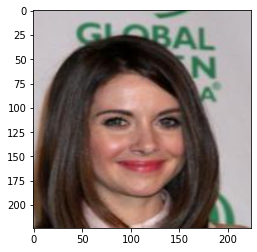

In [ ]:
img, label = valid_ds[1000]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], "Predicted: ", pred_img(img,model))
